In [6]:
import matplotlib.pyplot as plt 
import matplotlib.image as mtimage 
import numpy as np 
%matplotlib inline 
print(np.__version__)

1.22.4


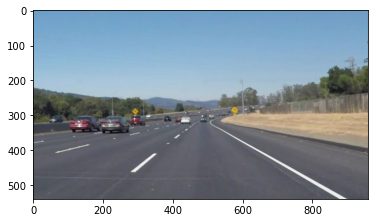

In [7]:
image = mtimage.imread("test.jpg")
plt.imshow(image)


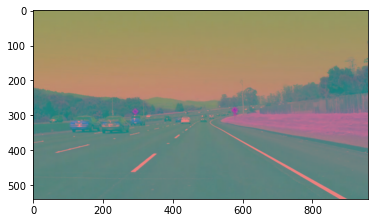

In [8]:
import cv2 
gray = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
plt.imshow(gray,cmap="gray")


In [9]:
import tensorflow as tf 

2022-06-10 05:16:59.064584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/monkey/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-10 05:16:59.064657: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
with tf.compat.v1.Session() as session :
    a = tf.constant(1)
    b = tf.constant(2)
    c = a+b
    print(session.run(c))

2022-06-10 05:17:33.109239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/monkey/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-10 05:17:33.109326: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 05:17:33.109394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2022-06-10 05:17:33.162976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 05:17:33.231998: I tenso

3


In [11]:
import imageio

from IPython.display import HTML


In [12]:

# test_clip = VideoFileClip("test.mp4")
# new_clip  = test_clip.fl_image(lambda x : cv2.cvtColor(x,cv2.COLOR_RGB2YUV))
# print(new_clip)
# %time new_clip.write_videofile(output_filename,audio=False)


In [31]:
 
def process_image(image):
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    kernel_size = 5
    blur_image = cv2.GaussianBlur(gray_image,(kernel_size,kernel_size),0)


    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_image,low_threshold,high_threshold)


    mask = np.zeros_like(edges)
    shape = image.shape
    ignore_color_mask = 255
    vertices = np.array([[(210,720),(450,290),(490,290),(1060,720)]],dtype=np.int32)
    cv2.fillPoly(mask,vertices,ignore_color_mask)
    masked_edges = cv2.bitwise_and(edges,mask)


    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_length = 40 
    max_line_gap = 20

    line_image = np.copy(image)*0

    lines = cv2.HoughLinesP(masked_edges,rho,theta,threshold,np.array([]),min_line_length,max_line_gap)

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),5)

    colored_edges = np.dstack((edges,edges,edges))
    combo = cv2.addWeighted(colored_edges,0.8,line_image,1,0)
    combo_with_original_image =  cv2.addWeighted(image,0.8,line_image,1,0)
    return combo_with_original_image

In [32]:
import cv2
capture = cv2.VideoCapture("test.mp4")
success, frame = capture.read()
shape = frame.shape
output_filename = "output.avi"
fourcc = cv2.VideoWriter_fourcc(*"XVID")
output_video = cv2.VideoWriter(output_filename,fourcc,20.0,(shape[1],shape[0]))

while success:
    success,frame = capture.read()
    if not success:
        break
    frame = process_image(frame)
#     print(frame)
    output_video.write(frame)
#     cv2.imshow("testvideo",frame)
    key = cv2.waitKey(1)
    if key == ord("s"):
        break
    
capture.release()
output_video.release()
cv2.destroyAllWindows()

[[[150 120  93]
  [150 121  94]
  [150 121  94]
  ...
  [145 114  74]
  [145 113  77]
  [143 111  75]]

 [[149 119  92]
  [150 120  93]
  [151 122  94]
  ...
  [145 114  74]
  [145 113  77]
  [143 111  75]]

 [[153 123  96]
  [151 122  94]
  [150 120  93]
  ...
  [145 113  77]
  [145 112  79]
  [145 112  79]]

 ...

 [[ 57  65  78]
  [ 58  66  80]
  [ 59  67  81]
  ...
  [ 42  49  65]
  [ 53  60  76]
  [ 57  64  80]]

 [[ 58  66  80]
  [ 58  66  80]
  [ 61  69  82]
  ...
  [ 30  38  54]
  [ 34  42  58]
  [ 45  52  68]]

 [[ 62  70  84]
  [ 59  67  81]
  [ 61  69  82]
  ...
  [ 30  37  53]
  [ 29  36  52]
  [ 42  50  66]]]
[[[150 119  95]
  [150 119  95]
  [150 119  94]
  ...
  [146 116  76]
  [145 115  71]
  [142 113  69]]

 [[150 119  95]
  [150 119  95]
  [150 119  94]
  ...
  [143 113  73]
  [144 114  70]
  [148 118  74]]

 [[150 119  94]
  [150 119  94]
  [150 119  94]
  ...
  [145 113  77]
  [145 115  73]
  [147 118  75]]

 ...

 [[ 58  66  82]
  [ 59  66  82]
  [ 59  66  82]
  ..

[[[149 120  90]
  [148 119  90]
  [150 121  91]
  ...
  [142 108  79]
  [144 109  82]
  [145 110  83]]

 [[149 120  90]
  [148 119  90]
  [150 121  91]
  ...
  [144 110  81]
  [144 109  82]
  [145 110  83]]

 [[149 120  90]
  [148 119  90]
  [149 120  90]
  ...
  [146 113  82]
  [144 110  80]
  [145 111  81]]

 ...

 [[ 62  64  82]
  [ 62  65  83]
  [ 62  65  83]
  ...
  [ 46  52  70]
  [ 58  64  82]
  [ 60  66  84]]

 [[ 62  64  82]
  [ 62  65  83]
  [ 62  65  83]
  ...
  [ 43  50  67]
  [ 57  63  81]
  [ 60  66  84]]

 [[ 62  64  82]
  [ 62  65  83]
  [ 62  65  83]
  ...
  [ 34  41  58]
  [ 40  46  64]
  [ 46  52  70]]]
[[[150 121  90]
  [150 121  90]
  [150 121  90]
  ...
  [145 112  78]
  [146 114  78]
  [146 114  78]]

 [[150 121  90]
  [150 121  90]
  [150 121  90]
  ...
  [146 114  79]
  [147 115  79]
  [147 115  79]]

 [[150 121  90]
  [150 121  90]
  [150 121  90]
  ...
  [145 114  75]
  [144 113  74]
  [144 113  74]]

 ...

 [[ 62  64  82]
  [ 62  65  83]
  [ 62  65  83]
  ..

[[[147 115  85]
  [148 116  86]
  [148 116  86]
  ...
  [145 112  78]
  [145 112  78]
  [145 112  78]]

 [[148 116  86]
  [149 117  86]
  [149 117  86]
  ...
  [144 111  77]
  [144 111  77]
  [144 111  77]]

 [[150 118  88]
  [151 119  89]
  [151 119  89]
  ...
  [143 110  76]
  [143 110  76]
  [143 110  76]]

 ...

 [[ 59  64  82]
  [ 60  65  82]
  [ 59  64  82]
  ...
  [ 45  50  67]
  [ 62  67  85]
  [ 65  70  87]]

 [[ 59  64  82]
  [ 59  64  82]
  [ 59  64  82]
  ...
  [ 42  47  65]
  [ 53  58  75]
  [ 56  61  78]]

 [[ 58  62  80]
  [ 58  63  81]
  [ 58  62  80]
  ...
  [ 32  37  54]
  [ 36  41  58]
  [ 41  46  63]]]
[[[151 119  89]
  [152 120  90]
  [152 120  90]
  ...
  [146 110  82]
  [146 110  82]
  [146 110  82]]

 [[150 118  88]
  [151 119  89]
  [151 119  89]
  ...
  [146 110  81]
  [146 110  82]
  [146 110  82]]

 [[149 117  86]
  [150 118  88]
  [150 118  88]
  ...
  [146 110  80]
  [146 111  81]
  [146 111  81]]

 ...

 [[ 58  63  81]
  [ 60  65  82]
  [ 60  65  82]
  ..

[[[149 115  89]
  [151 118  91]
  [151 118  91]
  ...
  [146 113  82]
  [146 112  83]
  [143 109  80]]

 [[150 117  90]
  [151 118  91]
  [151 118  91]
  ...
  [146 113  82]
  [146 112  83]
  [143 109  80]]

 [[151 118  90]
  [150 118  89]
  [151 118  90]
  ...
  [145 111  81]
  [145 111  81]
  [143 110  79]]

 ...

 [[ 58  65  82]
  [ 58  64  82]
  [ 58  65  82]
  ...
  [ 42  50  66]
  [ 58  66  82]
  [ 62  70  86]]

 [[ 57  66  82]
  [ 56  65  82]
  [ 56  65  82]
  ...
  [ 40  47  63]
  [ 57  64  80]
  [ 62  70  86]]

 [[ 57  66  82]
  [ 56  65  82]
  [ 56  65  82]
  ...
  [ 32  39  55]
  [ 39  46  62]
  [ 46  53  69]]]
[[[150 118  89]
  [150 118  89]
  [150 117  90]
  ...
  [143 110  74]
  [143 110  74]
  [144 110  74]]

 [[150 118  89]
  [150 118  89]
  [150 117  90]
  ...
  [143 110  74]
  [143 110  74]
  [144 110  74]]

 [[150 118  88]
  [150 118  88]
  [150 118  89]
  ...
  [143 112  70]
  [144 113  69]
  [145 114  70]]

 ...

 [[ 58  65  82]
  [ 58  65  82]
  [ 60  66  84]
  ..

[[[151 119  89]
  [153 121  90]
  [153 121  90]
  ...
  [136 104  78]
  [126  89  72]
  [121  84  67]]

 [[151 119  89]
  [154 122  91]
  [152 120  90]
  ...
  [130  98  73]
  [120  83  66]
  [112  75  58]]

 [[149 117  86]
  [151 119  89]
  [152 120  90]
  ...
  [126  94  69]
  [106  73  57]
  [ 96  62  46]]

 ...

 [[ 58  63  82]
  [ 59  64  83]
  [ 58  63  82]
  ...
  [ 47  54  71]
  [ 58  65  82]
  [ 65  71  89]]

 [[ 59  64  83]
  [ 60  65  84]
  [ 56  61  80]
  ...
  [ 41  47  65]
  [ 42  49  66]
  [ 47  54  71]]

 [[ 60  65  84]
  [ 60  65  84]
  [ 58  62  82]
  ...
  [ 36  42  60]
  [ 35  42  59]
  [ 39  46  63]]]
[[[154 122  90]
  [153 122  89]
  [151 120  87]
  ...
  [142 111  75]
  [140 112  75]
  [143 115  78]]

 [[154 122  90]
  [154 122  90]
  [150 119  86]
  ...
  [142 112  76]
  [141 113  76]
  [142 114  77]]

 [[152 121  88]
  [151 120  87]
  [150 119  86]
  ...
  [143 112  79]
  [142 112  81]
  [141 111  80]]

 ...

 [[ 61  66  83]
  [ 60  65  82]
  [ 60  65  82]
  ..

[[[ 54  66  68]
  [ 48  60  62]
  [ 40  53  58]
  ...
  [148 114  81]
  [150 115  82]
  [150 116  83]]

 [[ 60  72  74]
  [ 39  51  54]
  [ 38  50  56]
  ...
  [149 114  82]
  [150 115  82]
  [150 115  82]]

 [[ 66  78  82]
  [ 37  48  52]
  [ 37  47  54]
  ...
  [149 114  82]
  [149 114  82]
  [148 114  81]]

 ...

 [[ 58  64  82]
  [ 58  64  82]
  [ 59  66  83]
  ...
  [ 44  49  66]
  [ 60  65  82]
  [ 66  70  88]]

 [[ 59  66  83]
  [ 58  64  82]
  [ 58  65  82]
  ...
  [ 41  46  62]
  [ 48  54  70]
  [ 54  60  76]]

 [[ 59  66  83]
  [ 58  64  82]
  [ 59  66  83]
  ...
  [ 33  38  54]
  [ 34  39  55]
  [ 47  53  69]]]
[[[ 62  54  60]
  [ 74  66  71]
  [ 94  86  91]
  ...
  [148 114  78]
  [150 116  80]
  [150 117  81]]

 [[ 56  48  54]
  [ 74  66  71]
  [ 92  84  90]
  ...
  [149 115  79]
  [150 116  80]
  [150 116  80]]

 [[ 58  50  55]
  [ 70  62  67]
  [ 91  83  89]
  ...
  [149 115  79]
  [149 115  79]
  [148 114  78]]

 ...

 [[ 58  64  82]
  [ 58  64  82]
  [ 58  65  82]
  ..

[[[123  87  75]
  [121  85  73]
  [ 53  26  17]
  ...
  [151 116  78]
  [151 116  78]
  [151 116  78]]

 [[136 100  88]
  [121  85  73]
  [ 50  24  14]
  ...
  [151 116  78]
  [151 116  78]
  [151 116  78]]

 [[120  90  81]
  [ 86  56  47]
  [ 34  12   6]
  ...
  [151 116  78]
  [151 116  78]
  [151 116  78]]

 ...

 [[ 69  78  96]
  [ 73  82 100]
  [ 66  75  94]
  ...
  [ 49  54  71]
  [ 62  66  84]
  [ 66  71  89]]

 [[ 70  78  97]
  [ 70  79  98]
  [ 66  75  94]
  ...
  [ 42  46  64]
  [ 49  54  71]
  [ 54  58  76]]

 [[ 68  77  95]
  [ 67  76  94]
  [ 66  75  94]
  ...
  [ 38  42  60]
  [ 42  46  64]
  [ 46  51  69]]]
[[[  4  10  10]
  [ 14  20  19]
  [ 20  26  26]
  ...
  [151 115  80]
  [151 115  80]
  [151 115  80]]

 [[  4  10  10]
  [  5  11  10]
  [ 20  26  26]
  ...
  [151 115  80]
  [151 115  80]
  [151 115  80]]

 [[ 14  21  20]
  [  9  15  14]
  [  9  15  14]
  ...
  [151 115  80]
  [151 115  80]
  [151 115  80]]

 ...

 [[ 66  75  94]
  [ 70  79  98]
  [ 66  75  94]
  ..

[[[154 123  78]
  [154 123  78]
  [154 123  78]
  ...
  [152 118  71]
  [152 118  71]
  [149 115  68]]

 [[154 123  78]
  [154 123  78]
  [154 123  78]
  ...
  [151 118  70]
  [152 118  71]
  [150 116  69]]

 [[154 123  78]
  [154 123  78]
  [154 123  78]
  ...
  [150 116  69]
  [150 116  69]
  [151 118  70]]

 ...

 [[ 74  78  93]
  [ 74  78  93]
  [ 74  78  93]
  ...
  [ 66  67  84]
  [ 71  73  90]
  [ 70  72  89]]

 [[ 74  78  93]
  [ 74  78  93]
  [ 74  78  93]
  ...
  [ 58  59  76]
  [ 61  62  79]
  [ 61  62  79]]

 [[ 74  78  93]
  [ 74  78  93]
  [ 74  78  93]
  ...
  [ 59  61  78]
  [ 57  58  75]
  [ 59  61  78]]]
[[[154 120  77]
  [154 120  77]
  [154 120  77]
  ...
  [148 114  69]
  [148 114  69]
  [148 114  69]]

 [[154 120  77]
  [154 120  77]
  [154 120  77]
  ...
  [148 114  69]
  [148 114  69]
  [148 114  69]]

 [[154 120  77]
  [154 120  77]
  [154 120  77]
  ...
  [148 114  69]
  [148 114  69]
  [148 114  69]]

 ...

 [[ 75  78  95]
  [ 75  78  95]
  [ 77  80  97]
  ..

[[[146 110  71]
  [146 110  71]
  [146 110  71]
  ...
  [142 103  59]
  [142 103  59]
  [142 103  59]]

 [[146 110  71]
  [146 110  71]
  [146 110  71]
  ...
  [142 103  59]
  [142 103  59]
  [142 103  59]]

 [[146 110  71]
  [146 110  71]
  [146 110  71]
  ...
  [142 103  59]
  [142 103  59]
  [142 103  59]]

 ...

 [[ 63  65  82]
  [ 64  66  82]
  [ 66  67  84]
  ...
  [ 66  66  82]
  [ 66  66  82]
  [ 65  65  82]]

 [[ 62  64  81]
  [ 63  65  82]
  [ 65  66  83]
  ...
  [ 65  65  82]
  [ 63  63  80]
  [ 64  64  81]]

 [[ 58  60  77]
  [ 59  61  78]
  [ 62  63  80]
  ...
  [ 63  63  80]
  [ 61  61  78]
  [ 62  62  79]]]
[[[143 108  66]
  [143 108  66]
  [143 108  66]
  ...
  [142 102  60]
  [142 102  60]
  [142 102  60]]

 [[144 109  67]
  [144 109  67]
  [144 109  67]
  ...
  [142 102  60]
  [142 102  60]
  [142 102  60]]

 [[146 111  70]
  [146 111  70]
  [146 111  70]
  ...
  [142 102  60]
  [142 102  60]
  [142 102  60]]

 ...

 [[ 60  59  78]
  [ 59  58  77]
  [ 60  59  78]
  ..

[[[ 7 24 27]
  [ 0 12 15]
  [ 0 14 18]
  ...
  [26 50 52]
  [31 54 56]
  [31 54 56]]

 [[18 34 38]
  [ 0 13 16]
  [ 0 13 16]
  ...
  [10 34 36]
  [ 7 30 32]
  [ 6 29 30]]

 [[22 38 42]
  [ 6 23 26]
  [10 23 26]
  ...
  [ 4 25 27]
  [ 1 20 22]
  [ 0 17 19]]

 ...

 [[60 60 77]
  [60 60 77]
  [59 59 76]
  ...
  [74 76 89]
  [74 76 89]
  [72 74 86]]

 [[60 60 77]
  [60 60 77]
  [60 60 77]
  ...
  [74 76 89]
  [73 74 87]
  [71 73 86]]

 [[60 60 77]
  [60 60 77]
  [60 60 77]
  ...
  [73 74 87]
  [73 74 87]
  [71 73 86]]]
[[[ 9 32 29]
  [ 9 32 29]
  [18 39 36]
  ...
  [25 52 52]
  [12 38 38]
  [12 38 38]]

 [[12 35 32]
  [12 35 32]
  [20 42 38]
  ...
  [30 57 57]
  [30 56 56]
  [29 54 54]]

 [[10 34 30]
  [10 33 30]
  [16 38 34]
  ...
  [36 62 62]
  [38 62 62]
  [36 60 60]]

 ...

 [[60 60 77]
  [60 60 77]
  [59 59 76]
  ...
  [70 72 85]
  [70 71 84]
  [70 72 85]]

 [[61 61 78]
  [60 60 77]
  [60 60 77]
  ...
  [75 77 90]
  [75 77 90]
  [73 74 87]]

 [[61 61 78]
  [61 61 78]
  [60 60 77]
  .

[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [16 37 39]
  [19 37 38]
  [15 33 34]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [12 33 35]
  [18 36 38]
  [18 35 37]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 4 30 32]
  [15 41 41]
  [23 49 49]]

 ...

 [[44 42 58]
  [47 46 61]
  [48 46 62]
  ...
  [49 46 52]
  [40 38 43]
  [42 40 46]]

 [[44 42 58]
  [47 46 61]
  [47 46 61]
  ...
  [63 61 66]
  [61 58 64]
  [65 62 68]]

 [[45 43 58]
  [43 42 57]
  [43 42 57]
  ...
  [70 68 74]
  [65 62 68]
  [64 62 67]]]
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [16 50 50]
  [22 54 54]
  [18 51 51]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [22 57 57]
  [23 56 56]
  [13 46 46]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [24 57 57]
  [26 56 57]
  [18 48 49]]

 ...

 [[48 49 63]
  [48 49 63]
  [49 50 64]
  ...
  [78 79 92]
  [77 78 91]
  [76 78 90]]

 [[47 48 62]
  [48 49 63]
  [48 49 63]
  ...
  [74 76 89]
  [75 77 90]
  [76 78 90]]

 [[47 48 62]
  [47 48 62]
  [48 49 63]
  .

[[[150 114  74]
  [150 114  74]
  [150 114  74]
  ...
  [ 30  49  55]
  [ 36  58  63]
  [ 54  75  81]]

 [[149 113  74]
  [149 113  74]
  [149 113  74]
  ...
  [ 34  53  59]
  [ 34  55  61]
  [ 42  64  70]]

 [[148 113  71]
  [148 113  71]
  [148 113  71]
  ...
  [ 44  62  68]
  [ 34  53  59]
  [ 33  52  58]]

 ...

 [[ 58  58  75]
  [ 59  59  76]
  [ 60  60  77]
  ...
  [ 86  89  99]
  [ 83  86  96]
  [ 78  81  91]]

 [[ 57  57  74]
  [ 58  58  74]
  [ 59  59  76]
  ...
  [ 93  95 106]
  [ 91  94 104]
  [ 90  92 102]]

 [[ 58  58  74]
  [ 57  57  74]
  [ 59  59  76]
  ...
  [ 94  97 107]
  [ 93  95 106]
  [ 93  95 106]]]
[[[150 113  75]
  [150 113  75]
  [150 113  75]
  ...
  [ 39  50  45]
  [ 35  46  41]
  [ 34  44  39]]

 [[149 112  74]
  [149 112  74]
  [149 112  74]
  ...
  [ 39  50  45]
  [ 35  46  41]
  [ 34  44  39]]

 [[148 112  73]
  [148 112  73]
  [148 112  73]
  ...
  [ 42  50  45]
  [ 38  46  41]
  [ 36  43  38]]

 ...

 [[ 59  59  76]
  [ 58  58  75]
  [ 58  58  75]
  ..

[[[140 106  61]
  [141 106  62]
  [144 110  65]
  ...
  [142 108  61]
  [141 107  60]
  [141 107  60]]

 [[142 108  63]
  [143 109  64]
  [146 112  67]
  ...
  [142 109  62]
  [142 108  61]
  [142 108  61]]

 [[147 113  68]
  [148 114  69]
  [148 114  69]
  ...
  [143 110  62]
  [143 110  62]
  [143 110  62]]

 ...

 [[ 62  63  78]
  [ 58  59  74]
  [ 60  61  75]
  ...
  [ 89  89 100]
  [ 84  84  95]
  [ 82  82  93]]

 [[ 59  60  74]
  [ 59  60  74]
  [ 61  62  76]
  ...
  [104 104 115]
  [ 99  99 110]
  [ 94  94 106]]

 [[ 54  55  70]
  [ 58  59  74]
  [ 60  61  75]
  ...
  [ 93  93 104]
  [ 91  91 102]
  [ 90  90 102]]]
[[[150 110  82]
  [149 109  81]
  [149 110  80]
  ...
  [138 107  53]
  [141 110  55]
  [142 110  56]]

 [[150 110  82]
  [149 109  81]
  [148 109  79]
  ...
  [142 111  57]
  [144 113  58]
  [146 114  60]]

 [[150 110  81]
  [149 110  80]
  [149 110  78]
  ...
  [143 111  60]
  [146 114  62]
  [146 114  63]]

 ...

 [[ 60  61  75]
  [ 58  59  74]
  [ 61  62  76]
  ..

[[[152 114  79]
  [151 114  78]
  [149 111  76]
  ...
  [107  87  80]
  [118  98  85]
  [126 106  93]]

 [[152 114  79]
  [151 114  78]
  [149 111  76]
  ...
  [103  83  76]
  [110  90  77]
  [114  94  82]]

 [[151 113  79]
  [150 111  78]
  [149 111  76]
  ...
  [ 94  76  74]
  [104  86  80]
  [104  86  80]]

 ...

 [[ 59  58  77]
  [ 60  59  78]
  [ 59  58  77]
  ...
  [ 85  85  96]
  [ 83  83  94]
  [ 86  86  97]]

 [[ 60  59  78]
  [ 58  57  75]
  [ 58  57  75]
  ...
  [ 90  90 102]
  [ 89  89 100]
  [ 90  90 102]]

 [[ 58  58  76]
  [ 57  56  74]
  [ 57  56  74]
  ...
  [ 88  88  99]
  [ 90  90 101]
  [ 89  89 100]]]
[[[152 114  82]
  [151 113  81]
  [149 110  77]
  ...
  [118  96  83]
  [114  88  76]
  [109  83  71]]

 [[152 114  82]
  [151 113  81]
  [149 110  77]
  ...
  [118  96  83]
  [114  88  76]
  [110  84  72]]

 [[151 113  81]
  [150 111  79]
  [149 110  77]
  ...
  [108  87  77]
  [104  82  71]
  [101  78  68]]

 ...

 [[ 55  54  73]
  [ 62  62  80]
  [ 59  58  77]
  ..

[[[149 111  76]
  [149 111  76]
  [149 111  76]
  ...
  [145 109  64]
  [144 110  59]
  [144 110  59]]

 [[149 111  76]
  [149 111  76]
  [149 111  76]
  ...
  [147 111  66]
  [147 114  62]
  [147 114  62]]

 [[149 112  74]
  [149 112  74]
  [149 112  74]
  ...
  [147 110  67]
  [143 108  61]
  [142 106  59]]

 ...

 [[ 58  58  75]
  [ 59  59  76]
  [ 61  61  78]
  ...
  [ 94  93 108]
  [ 91  90 104]
  [ 89  88 102]]

 [[ 57  57  74]
  [ 61  61  78]
  [ 63  63  80]
  ...
  [ 97  95 110]
  [ 95  94 108]
  [ 91  90 104]]

 [[ 57  57  74]
  [ 61  61  78]
  [ 63  63  80]
  ...
  [ 90  88 103]
  [ 88  87 101]
  [ 86  85  98]]]
[[[151 114  78]
  [151 114  78]
  [151 114  77]
  ...
  [144 110  65]
  [144 110  65]
  [144 110  65]]

 [[150 112  77]
  [150 112  77]
  [150 113  75]
  ...
  [144 110  65]
  [144 110  65]
  [144 110  65]]

 [[148 111  74]
  [148 111  74]
  [148 112  73]
  ...
  [144 109  66]
  [144 109  66]
  [144 109  66]]

 ...

 [[ 60  60  77]
  [ 60  60  77]
  [ 62  62  79]
  ..

[[[150 113  79]
  [148 111  78]
  [146 110  75]
  ...
  [146 110  71]
  [147 111  72]
  [148 112  73]]

 [[148 111  78]
  [148 111  78]
  [147 111  76]
  ...
  [146 110  71]
  [147 111  72]
  [147 111  72]]

 [[146 110  75]
  [147 111  76]
  [148 112  77]
  ...
  [146 110  71]
  [147 111  72]
  [147 111  72]]

 ...

 [[ 58  60  77]
  [ 58  59  76]
  [ 58  60  77]
  ...
  [ 57  58  71]
  [ 65  66  79]
  [ 66  67  80]]

 [[ 58  59  76]
  [ 59  61  78]
  [ 62  63  80]
  ...
  [ 59  61  74]
  [ 66  67  80]
  [ 66  68  81]]

 [[ 62  63  80]
  [ 62  63  80]
  [ 59  61  78]
  ...
  [ 49  50  63]
  [ 55  57  70]
  [ 58  59  72]]]
[[[148 113  75]
  [147 112  74]
  [146 111  72]
  ...
  [149 111  76]
  [147 110  74]
  [146 108  73]]

 [[147 112  74]
  [147 112  74]
  [146 112  73]
  ...
  [148 110  75]
  [147 110  74]
  [146 108  73]]

 [[146 111  72]
  [146 112  73]
  [147 113  74]
  ...
  [146 110  72]
  [146 110  72]
  [146 110  72]]

 ...

 [[ 61  62  79]
  [ 62  63  80]
  [ 59  61  78]
  ..

[[[145 110  71]
  [145 110  71]
  [146 111  72]
  ...
  [146 110  67]
  [147 112  69]
  [148 113  70]]

 [[146 111  72]
  [146 111  72]
  [146 111  72]
  ...
  [146 110  67]
  [146 110  67]
  [146 111  68]]

 [[146 112  73]
  [146 112  73]
  [146 112  73]
  ...
  [144 109  66]
  [143 108  65]
  [142 107  64]]

 ...

 [[ 58  60  78]
  [ 57  59  78]
  [ 58  60  78]
  ...
  [ 49  50  64]
  [ 60  61  75]
  [ 69  70  84]]

 [[ 55  60  78]
  [ 54  59  77]
  [ 59  62  80]
  ...
  [ 42  42  57]
  [ 49  50  64]
  [ 58  59  74]]

 [[ 55  60  78]
  [ 54  59  77]
  [ 59  62  80]
  ...
  [ 37  38  52]
  [ 42  42  57]
  [ 53  54  68]]]
[[[146 110  75]
  [146 110  75]
  [146 110  75]
  ...
  [142 107  64]
  [141 106  62]
  [146 110  67]]

 [[146 110  75]
  [146 110  75]
  [146 110  75]
  ...
  [142 107  64]
  [142 107  64]
  [144 109  66]]

 [[146 110  75]
  [146 110  75]
  [146 110  75]
  ...
  [143 108  65]
  [144 109  66]
  [143 108  65]]

 ...

 [[ 54  59  75]
  [ 55  61  77]
  [ 55  61  77]
  ..